In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlxtend

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
FILE_PATH = 'YouTube Videos - Sheet1.csv'
data = pd.read_csv(FILE_PATH)
data

,headline,clickbait,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Gravitas: China moves 100 rocket launchers to ...,0,NaN,NaN,NaN,NaN,NaN,NaN
1,"Sudan general declares state of emergency, \nd...",0,NaN,NaN,NaN,NaN,NaN,NaN
2,India Deploys The Most Lethal Multi-Rocket Lau...,0,NaN,NaN,NaN,NaN,NaN,NaN
3,Covid cases rising in UK - what happens next? ...,0,NaN,NaN,NaN,NaN,NaN,NaN
4,"Newspaper Readership Then, Now and in the Future",0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
244,150K PAR HEURE TRES FACILEMENT - WOW SHADOWLAN...,0,NaN,NaN,NaN,NaN,NaN,NaN
245,ПРОЩАНИЕ С АРТАСОМ - НОВЫЙ СИНЕМАТИК! | Shadow...,0,NaN,NaN,NaN,NaN,NaN,NaN
246,The most EFFICIENT Classic WoW Leveler!,0,NaN,NaN,NaN,NaN,NaN,NaN
247,MARSO x BOBKATA - WOW [Official Music Video],0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
text = data['headline'].values
labels = data['clickbait'].values
text_train, text_test, y_train, y_test = train_test_split(text, labels)
print(text_train.shape, text_test.shape, y_train.shape, y_test.shape)

(186,) (63,) (186,) (63,)


In [6]:
vocab_size = 5000
maxlen = 500
embedding_size = 32

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(text)

X_train = tokenizer.texts_to_sequences(text_train)
x_test = tokenizer.texts_to_sequences(text_test)

X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [7]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 500, 32)           8320      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
__________________________________________________

In [8]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=512, validation_data=(x_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5000
Epoch 1: val_accuracy improved from -inf to 0.68254, saving model to weights.h5
1/1 [==============================] - 4s 4s/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6891 - val_accuracy: 0.6825
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.6398
Epoch 2: val_accuracy did not improve from 0.68254
1/1 [==============================] - 1s 688ms/step - loss: 0.6895 - accuracy: 0.6398 - val_loss: 0.6862 - val_accuracy: 0.6825
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.6452
Epoch 3: val_accuracy did not improve from 0.68254
1/1 [==============================] - 1s 588ms/step - loss: 0.6867 - accuracy: 0.6452 - val_loss: 0.6835 - val_accuracy: 0.6825
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.6452
Epoch 4: val_accuracy did not improve from 0.68254
1/1 [==========

In [10]:
model.load_weights('weights.h5')
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


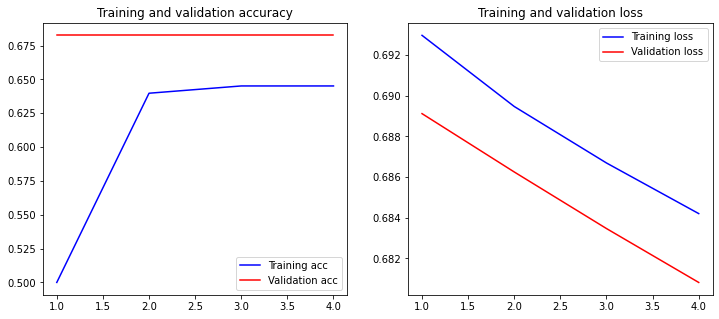

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

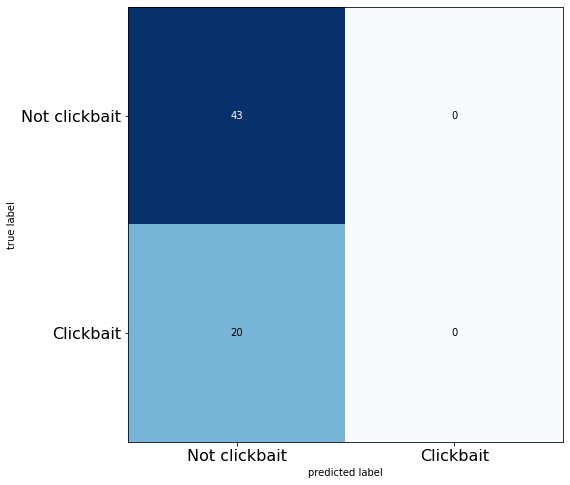

In [12]:
preds = [round(i[0]) for i in model.predict(x_test)]
cm = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.yticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.show()

In [13]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.00
Precision of the model is nan


<ipython-input-13-54691c532bee>:3: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp/(tp+fp)


In [15]:
test = ['Courteney Cox Becomes Friends With Spicy Wings | Hot Ones']
token_text = pad_sequences(tokenizer.texts_to_sequences(test), maxlen=maxlen)
preds = [round(i[0]) for i in model.predict(token_text)]
for (text, pred) in zip(test, preds):
    label = 'Clickbait' if pred == 1.0 else 'Not Clickbait'
    print("{} - {}".format(text, label))

Courteney Cox Becomes Friends With Spicy Wings | Hot Ones - Not Clickbait
